## Standardize the item response data

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from funcs import *
from clustering import *
from matplotlib import pyplot as plt

from pca import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

## load data

In [2]:
data = pd.read_csv('data/pretest_data.csv')
# data = pd.read_excel('data/pretest_data.xlsx')  # error loading xlsx
# data.head()

In [3]:
response_data = np.array(data.drop(columns=['학번','성적/10']))
# response_data = data.drop(columns=['학번','성적/10'])

array([0.51578947, 0.29473684, 0.66315789, 0.50526316, 0.42105263,
       0.53684211, 0.42105263, 0.47368421, 0.42105263, 0.24210526])

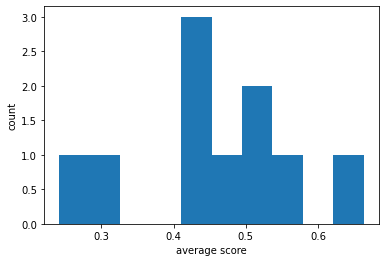

In [4]:
plt.hist(np.mean(response_data, axis=0))
plt.xlabel('average score')
plt.ylabel('count')

np.mean(response_data, axis=0)

In [5]:
np.std(response_data, axis=0)

array([0.49975063, 0.45592438, 0.47263041, 0.4999723 , 0.49372797,
       0.49864081, 0.49372797, 0.499307  , 0.49372797, 0.42835768])

In [6]:
items_for_each_component = {'Repetition':[1],'Probability':[2,3],'Conditional_Probablity':[4,5],
                            'Random_Variable':[6,7],'Probability_Distribution':[8,9],'Statistical_Estimation':[10]}

## Choose param

In [7]:
# param = {'standardize': 'z',
#          'dim_reduction': 'pca',
#          'clustering': 'gmm'}

param = {'standardize': 'z',
         'dim_reduction': 'rpca',
         'clustering': 'gmm'}

# param = {'standardize': 'centering',
#          'dim_reduction': 'pca',
#          'clustering': 'gmm'}

# param = {'standardize': 'centering',
#          'dim_reduction': 'rpca',
#          'clustering': 'gmm'}

# param = {'standardize': 'centering',
#          'dim_reduction': 'none',
#          'clustering': 'gmm'}


param['str'] = param['standardize'] + '_' + param['dim_reduction'] + '_' + param['clustering']

param

{'standardize': 'z',
 'dim_reduction': 'rpca',
 'clustering': 'gmm',
 'str': 'z_rpca_gmm'}

## Standardize

In [8]:
if param['standardize'] == 'z':
    # standardize
    processed_data = (response_data - np.mean(response_data, axis=0)) / np.std(response_data, axis=0)
elif param['standardize'] == 'centering':
    processed_data = response_data - 0.5    
elif param['standardize'] == 'none':
    processed_data = response_data
    
np.std(processed_data, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Dimension reduction

/Users/yyoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.234840017662493 > -74.574995286371959). You may want to try with a higher value of support_fraction (current value: 0.558).
  RuntimeWarning)
/Users/yyoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.080539312162975 > -74.868731770501967). You may want to try with a higher value of support_fraction (current value: 0.558).
  RuntimeWarning)
/Users/yyoo/opt/anaconda3/lib/python3.7/site-packages/sklearn/covariance/_robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-4.116609293104914 > -74.736800265372324). You may want to try with a higher value of support_fraction (current value: 

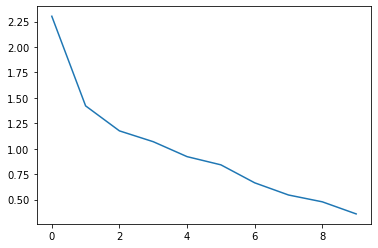

In [9]:
if param['dim_reduction'] == 'pca':
    fit_pca = PCA(n_components=7, random_state=0).fit_transform(processed_data)
elif param['dim_reduction'] == 'rpca':
    robust_covariance_mat = make_robust_covariance_mat(processed_data, centered = True)
    eig_values, eig_vectors = make_eig_values_and_vectors(robust_covariance_mat)
    sorted_eig_values, sorted_eig_vectors = sort_eigen_pair(eig_values, eig_vectors)
    
    plt.plot(sorted_eig_values)
    
    fit_pca = project(processed_data, sorted_eig_vectors)[:,0:7]
else:
    fit_pca = processed_data
    print('no dimension reduction')

## Cluster using Gaussian Mixture Model (GMM)

Total score distribution in GMM

In [10]:
# Number of components in GMM
num_components = 5

In [11]:
gmm = GaussianMixture(n_components=num_components, random_state=0)

In [12]:
gmm.fit(fit_pca)

GaussianMixture(n_components=5, random_state=0)

In [13]:
gmm_labels = gmm.predict(fit_pca)

In [14]:
sorted_index = np.argsort([np.mean(np.mean(processed_data[gmm_labels == i] ,axis=0)) for i in range(num_components)])[::-1]

In [15]:
df_gmm = pd.DataFrame(fit_pca)
df_gmm['cluster_gmm'] = sort_categories_by_mean(gmm_labels, sorted_index)

In [16]:
gmm_cluster_index = df_gmm['cluster_gmm']

In [17]:
data['cluster_index'] = df_gmm['cluster_gmm']

In [18]:
# data.head(3)

In [19]:
# save ID and cluster index to a csv file
data[['학번','cluster_index']].to_csv('results/pretest_{}.csv'.format(param['str']), index=None)

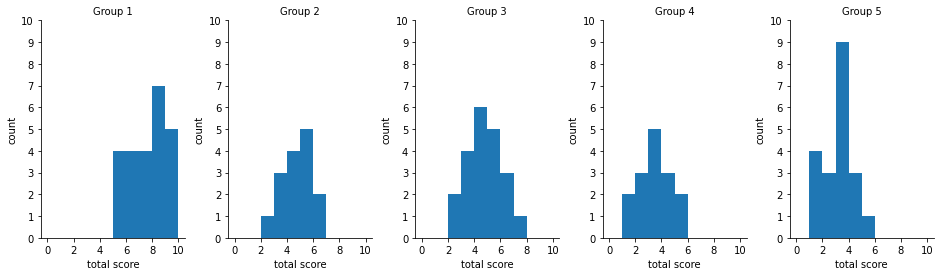

In [20]:
plt.figure(figsize=(16,4))
bins = np.linspace(0,10,11)
for i in range(num_components):
    plt.subplot(1,num_components,i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Group ' + str(i+1), fontsize=10)
    plt.xlabel('total score')
    plt.ylabel('count', fontsize=10)
    plt.hist(np.sum(response_data[df_gmm['cluster_gmm'] == i+1], axis = 1), bins = bins)
    plt.xticks(np.arange(0,11,2))
    plt.yticks(np.arange(0,11,1))
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

Itemwise score in GMM

In [21]:
# plot response data (compared with mean)
itemwise_gmm = [np.mean(response_data[df_gmm['cluster_gmm'] == i+1], axis=0) for i in range(num_components)]
# itemwise_gmm = [np.mean(processed_data[df_gmm['cluster_gmm'] == i+1], axis=0) for i in range(num_components)]

itemwise_gmm

[array([0.70833333, 0.54166667, 1.        , 1.        , 0.66666667,
        0.875     , 0.58333333, 1.        , 0.66666667, 0.20833333]),
 array([0.73333333, 0.        , 0.46666667, 0.13333333, 0.2       ,
        0.33333333, 1.        , 0.33333333, 0.46666667, 0.6       ]),
 array([0.28571429, 0.33333333, 0.80952381, 0.14285714, 0.42857143,
        1.        , 0.47619048, 0.38095238, 0.38095238, 0.04761905]),
 array([0.6       , 0.        , 0.        , 0.66666667, 0.53333333,
        0.2       , 0.        , 0.4       , 0.33333333, 0.26666667]),
 array([0.3 , 0.4 , 0.75, 0.45, 0.2 , 0.05, 0.05, 0.1 , 0.2 , 0.2 ])]

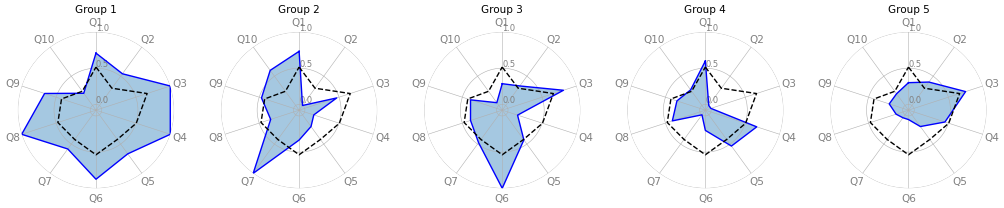

In [22]:
my_dpi=50
plt.figure(figsize=(1250/my_dpi, 750/my_dpi), dpi=my_dpi)

items = ['Q'+ str(i+1) for i in range(processed_data.shape[1])]

for row in range(0, len(itemwise_gmm)):
    ax = plt.subplot(1,num_components,row + 1, polar=True)
    plt.subplots_adjust(wspace=0.3)

    values = itemwise_gmm[row]
    
    plot_spider(items, values)
    # plot average
    plot_spider(items, np.mean(response_data, axis=0), linestyle = 'dashed', color='k', fill=False)
        
    plt.title('Group ' + str(row + 1), size=15, y=1.1)
plt.savefig('figure/pretest_{}_spider_item.pdf'.format(param['str']), bbox_inches='tight')    

Componentwise score in GMM

In [23]:
componentwise_gmm = list()

for i in range(1, num_components + 1):    
    componentwise_gmm.append(calc_mean_components_by_group(items_for_each_component, itemwise_gmm, i))

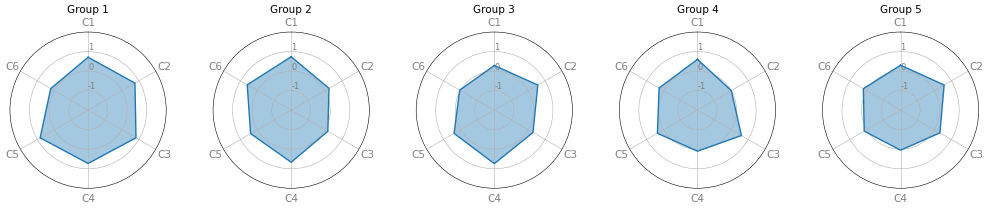

In [24]:
my_dpi=50
plt.figure(figsize=(1250/my_dpi, 750/my_dpi), dpi=my_dpi)

components = ['C'+str(i+1) for i in range(len(items_for_each_component.keys()))]

for row in range(0, len(componentwise_gmm)):
    ax = plt.subplot(1,num_components,row + 1, polar=True)
    plt.subplots_adjust(wspace=0.3)
    values = componentwise_gmm[row].values()
    make_spider(components, values, ax, 'Group '+ str(row + 1), linestyle = 'solid')

## visualize clustering results

In [25]:
shapes = [[], 'o','^', '*', 's', 'd']
colors = [[], 'b', 'r', 'c', 'k', 'g']

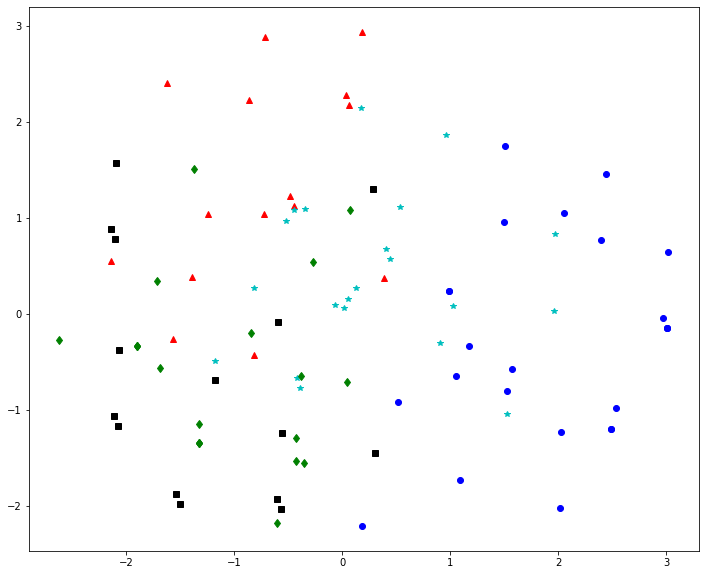

In [26]:
# visualize with PCA

plt.figure(figsize=(12,10))
for c in range(1,6):
    idx = np.where(data['cluster_index']==c)

    plt.plot(fit_pca[idx,0], fit_pca[idx,1], shapes[c]+colors[c])

plt.savefig('figure/pretest_{}_pca.pdf'.format(param['str']), bbox_inches='tight')

In [27]:
from sklearn.manifold import TSNE

response_embedded = TSNE(n_components=2, random_state=0).fit_transform(response_data)
response_embedded.shape

(95, 2)

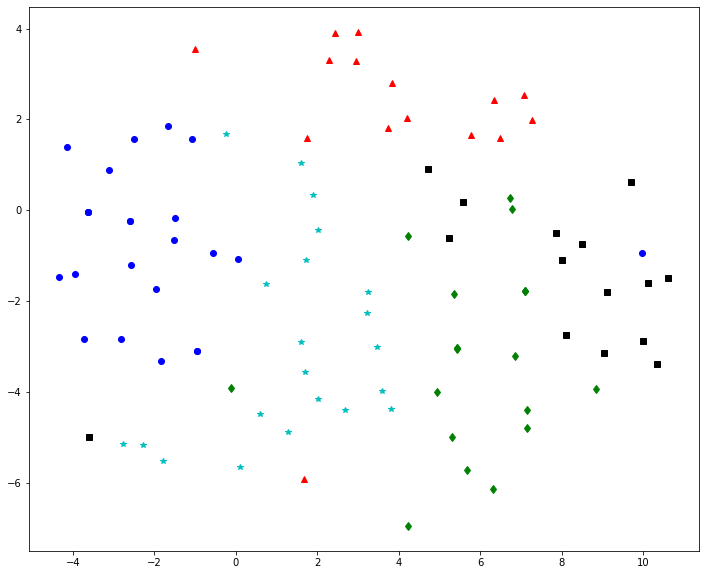

In [28]:
plt.figure(figsize=(12,10))
for c in range(1,6):
    idx = np.where(data['cluster_index']==c)

    plt.plot(response_embedded[idx,0], response_embedded[idx,1], shapes[c]+colors[c])
    
plt.savefig('figure/pretest_{}_tsne.pdf'.format(param['str']), bbox_inches='tight')